# **YOLO-CIANNA SDC1 example script**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Deyht/CIANNA/blob/CIANNA/examples/SKAO_SDC1/sdc1_pred_notebook.ipynb)

---


**Link to the CIANNA github repository**
https://github.com/Deyht/CIANNA

## SDC1 prediction network

This notebook is a simplified version of the scripts used in Cornu et al. 2024 ([arxiv:2402.05925](https://ui.adsabs.harvard.edu/link_gateway/2024arXiv240205925C/arxiv:2402.05925))
presenting the application of the YOLO-CIANNA method over the SKAO SDC1 dataset.
This notebook can be used to reproduce the reference result of the paper by
downloading the corresponding saved network model (available at [10.5281/zenodo.12801421](https://doi.org/10.5281/zenodo.12801421)). Note that we also provide the alternative-training larger model at the same link, which is better suited for transfer learning over other datasets.

This notebook does not re-train a network from scratch, it only load the trained model,
and do the prediction over the full image.
Training scripts are provided in the SDC1 example directory in the CIANNA repository/

Most of the data processing work is done in aux_fct.py and data_gen.py.
We strongly encourage having a look at this script to understand the processing done in this notebook.


## 1- **CIANNA installation**

#### Query GPU allocation and properties

If nvidia-smi fail, it might indicate that you launched the colab session whithout GPU reservation.  
To change the type of reservation go to "Runtime"->"Change runtime type" and select "GPU" as your hardware accelerator.

In [1]:
%%shell

nvidia-smi

cd /content/

git clone https://github.com/NVIDIA/cuda-samples/

cd /content/cuda-samples/Samples/1_Utilities/deviceQuery/

make SMS="50 60 70 80"

./deviceQuery | grep Capability | cut -c50- > ~/cuda_infos.txt
./deviceQuery | grep "CUDA Driver Version / Runtime Version" | cut -c57- >> ~/cuda_infos.txt

cd ~/

Tue Jul 23 16:59:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

If you are granted a GPU that does not support FP16 computation, it is advised to change the mixed precision method to FP32C_FP32A in the corresponding cells.
See the detail description on mixed precision support with CIANNA on the [Systeme Requirements](https://github.com/Deyht/CIANNA/wiki/1\)-System-Requirements) wiki page.

#### Clone CIANNA git repository

In [2]:
%%shell

cd /content/

git clone https://github.com/Deyht/CIANNA

cd CIANNA

Cloning into 'CIANNA'...
remote: Enumerating objects: 2098, done.
remote: Counting objects: 100% (527/527), done.
remote: Compressing objects: 100% (168/168), done.
remote: Total 2098 (delta 374), reused 507 (delta 357), pack-reused 1571
Receiving objects: 100% (2098/2098), 61.82 MiB | 24.28 MiB/s, done.
Resolving deltas: 100% (1556/1556), done.


#### Compiling CIANNA for the allocated GPU generation

There is no guaranteed forward or backward compatibility between Nvidia GPU generation, and some capabilities are generation specific. For these reasons, CIANNA must be provided the platform GPU generation at compile time.
The following cell will automatically update all the necessary files based on the detected GPU, and compile CIANNA.

In [3]:
%%shell

cd /content/CIANNA

mult="10"
cat ~/cuda_infos.txt
comp_cap="$(sed '1!d' ~/cuda_infos.txt)"
cuda_vers="$(sed '2!d' ~/cuda_infos.txt)"

lim="11.1"
old_arg=$(awk '{if ($1 < $2) print "-D CUDA_OLD";}' <<<"${cuda_vers} ${lim}")

sm_val=$(awk '{print $1*$2}' <<<"${mult} ${comp_cap}")

gen_val=$(awk '{if ($1 >= 80) print "-D GEN_AMPERE"; else if($1 >= 70) print "-D GEN_VOLTA";}' <<<"${sm_val}")

sed -i "s/.*arch=sm.*/\\t\tcuda_arg=\"\$cuda_arg -D CUDA -D comp_CUDA -lcublas -lcudart -arch=sm_$sm_val $old_arg $gen_val\"/g" compile.cp
sed -i "s/\/cuda-[0-9][0-9].[0-9]/\/cuda-$cuda_vers/g" compile.cp
sed -i "s/\/cuda-[0-9][0-9].[0-9]/\/cuda-$cuda_vers/g" src/python_module_setup.py

./compile.cp CUDA PY_INTERF

mv src/build/lib.linux-x86_64-* src/build/lib.linux-x86_64

7.5
12.2
USE_CUDA
BUILD PY_INTERF
#####  End of CUDA compilation  #####
#####  End of main program compilation  #####
#####  End of link edition and executable creation  #####
USE_CUDA
running build
running build_ext
building 'CIANNA' extension
creating build
creating build/temp.linux-x86_64-cpython-310
x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC -DMAX_LAYERS_NB=200 -DMAX_NETWORKS_NB=10 -DCUDA=1 -DCUDA_THREADS_PER_BLOCKS=256 -DNone -I/usr/local/cuda-12.2/include -I/usr/local/lib/python3.10/dist-packages/numpy/core/include -I/usr/include/python3.10 -c python_module.c -o build/temp.linux-x86_64-cpython-310/python_module.o
creating build/lib.linux-x86_64-cpython-310
x86_64-linux-gnu-gcc -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-Bsymbolic-functions -g -fwrapv -O2 build/temp.linux-x86_64-cpython-310/python_module.o conv_layer.o dense_layer.o pool_layer.o norm_layer.

#### CIANNA notebook guideline

**IMPORTANT NOTE**   
CIANNA is mainly used in a script fashion and was not designed to run in notebooks. Every cell code that directly invokes CIANNA functions must be run as a script to avoid possible errors.  
To do so, the cell must have the following structure.

```
%%shell

cd /content/CIANNA

python3 - <<EOF

[... your python code ...]

EOF
```

This syntax allows one to easily edit python code in the notebook while running the cell as a script. Note that all the notebook variables can not be accessed by the cell in this context.


## 2 - Detector prediction
Run pred_network.py whith no parameters after updating the cnn.init() parameters for your config
*   It will download the trained model
*   It will perform a prediction on the full image and save it in raw prediction formal


In [4]:
%%shell

pip install ska_sdc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 kB 2.0 MB/s eta 0:00:00


In [5]:

%%shell

cd /content/CIANNA/examples/SKAO_SDC1/

python3 - <<EOF

from threading import Thread
from data_gen import *

#Comment to access system wide install
sys.path.insert(0,glob.glob("../../src/build/lib.*/")[-1])
import CIANNA as cnn


def i_ar(int_list):
    return np.array(int_list, dtype="int")

def f_ar(float_list):
    return np.array(float_list, dtype="float32")

#Construct training set using custom selection function
dataset_perscut(data_path+"TrainingSet_B1_v2.txt",data_path+"TrainingSet_perscut.txt", 18) #18 is the number of header line removed

#Prediction is done in mixed_precision="FP16C_FP32A" to save RAM, it has almost no impact on the score
#It could alternatively be run with a batch size of 4 to run with mixed_precision="FP32C_FP32A"
cnn.init(in_dim=i_ar([fwd_image_size,fwd_image_size]), in_nb_ch=1, out_dim=1+max_nb_obj_per_image*(7+nb_param),
    bias=0.1, b_size=8, comp_meth="C_CUDA", dynamic_load=1, mixed_precision="FP16C_FP32A", adv_size=30, inference_only=1)

lims = [[-6.214608098422191418e+00, -1.313647296682372989e+01],
        [4.094344562222100414e+00 , -1.053605156578262814e-01],
        [3.401197381662155461e+00 , -1.203972804325936119e+00]]

np.savetxt("train_cat_norm_lims.txt", lims)

#Re-build norm, since this function can be called without data_gen_init

pred_all = np.zeros((nb_images_all,fwd_image_size*fwd_image_size), dtype="float32")
patch = np.zeros((fwd_image_size,fwd_image_size), dtype="float32")

for i_d in range(0,nb_images_all):

  p_y = int(i_d/nb_area_w)
  p_x = int(i_d%nb_area_w)

  xmin = p_x*patch_shift - orig_offset
  xmax = p_x*patch_shift + fwd_image_size - orig_offset
  ymin = p_y*patch_shift - orig_offset
  ymax = p_y*patch_shift + fwd_image_size - orig_offset

  px_min = 0; px_max = fwd_image_size
  py_min = 0; py_max = fwd_image_size

  set_zero = 0

  if(xmin < 0):
    px_min = -xmin; xmin = 0; set_zero = 1
  if(ymin < 0):
    py_min = -ymin; ymin = 0; set_zero = 1
  if(xmax > map_pixel_size):
    px_max = fwd_image_size - (xmax-map_pixel_size); xmax = map_pixel_size; set_zero = 1
  if(ymax > map_pixel_size):
    py_max = fwd_image_size - (ymax-map_pixel_size); ymax = map_pixel_size; set_zero = 1

  if(set_zero):
    patch[:,:] = 0.0

  patch[py_min:py_max,px_min:px_max] = full_img[ymin:ymax,xmin:xmax]
  patch = np.clip(patch,min_pix,max_pix)
  patch = (patch - min_pix) / (max_pix-min_pix)
  patch = np.tanh(3.0*patch)
  pred_all[i_d,:] = patch.flatten("C")

input_data = pred_all
nb_images_all = np.shape(input_data)[0]
targets = np.zeros((nb_images_all,1+max_nb_obj_per_image*(7+nb_param)), dtype="float32")

del (full_img)

cnn.create_dataset("TEST", nb_images_all, input_data[:,:], targets[:,:])

del (input_data, pred_all, targets)

nb_yolo_filters = cnn.set_yolo_params(raw_output=0)

load_epoch = 0
if (len(sys.argv) > 1):
    load_epoch = int(sys.argv[1])

if(load_epoch > 0):
    cnn.load("net_save/net0_s%04d.dat"%load_epoch, load_epoch, bin=1)
else:
    if(not os.path.isfile(data_path+"YOLO_CIANNA_ref_SDC1_s480k_MINERVA_Cornu2024.dat")):
            os.system("wget -P %s https://zenodo.org/records/12801421/files/YOLO_CIANNA_ref_SDC1_s480k_MINERVA_Cornu2024.dat"%(data_path))
    cnn.load(data_path+"YOLO_CIANNA_ref_SDC1_s480k_MINERVA_Cornu2024.dat", 0, bin=1)

cnn.forward(no_error=1, saving=2, repeat=1, drop_mode="AVG_MODEL")

EOF

--2024-07-23 17:01:17--  https://owncloud.ia2.inaf.it/index.php/s/hbasFhd4YILNkCr/download
Resolving owncloud.ia2.inaf.it (owncloud.ia2.inaf.it)... 140.105.79.202
Connecting to owncloud.ia2.inaf.it (owncloud.ia2.inaf.it)|140.105.79.202|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4294981440 (4.0G) [application/octet-stream]
Saving to: ‘./SDC1_data/SKAMid_B1_1000h_v3.fits’

SKAMid_B1_1000h_v3. 100%[===================>]   4.00G  15.5MB/s    in 4m 33s  

2024-07-23 17:05:51 (15.0 MB/s) - ‘./SDC1_data/SKAMid_B1_1000h_v3.fits’ saved [4294981440/4294981440]

./SDC1_data/SKAMid_B1_1000h_v3.fits
--2024-07-23 17:05:51--  https://owncloud.ia2.inaf.it/index.php/s/ZbaSDe7zGBYgxL1/download
Resolving owncloud.ia2.inaf.it (owncloud.ia2.inaf.it)... 140.105.79.202
Connecting to owncloud.ia2.inaf.it (owncloud.ia2.inaf.it)|140.105.79.202|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 279360 (273K) [application/octet-stream]
Saving to: ‘./SDC1_data/

## 3. Post - Processing ang visualisation

Run the pred_visual.py script to generate all the figures and compute the complete score.

We recommend looking at the captions in the paper for a full figure description.

In [6]:
%cd /content/CIANNA/examples/SKAO_SDC1/

from data_gen import *

load_iter = 0

#Obj thresholds should be optimize for specif training or iter (using post_process.py)

#For best score (YOLO-CIANNA-ref)
prob_obj_cases = np.array([0.3101, 0.2759, 0.1536, 0.3101, 0.2759, 0.2314, 0.1146, 0.0962, 0.0468])

#For good precision (YOLO-CIANNA-alt)
#prob_obj_cases = np.array([0.678, 0.6271, 0.4915, 0.678, 0.6441, 0.6102, 0.7288, 0.7458, 0.8305])

#To sample the full mAP curve (require low value for all)
#prob_obj_cases = np.array([0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03])

#Data normalization to display the dynamic of the network input

for i in range(0,np.shape(full_img)[0]):
  full_img[i,:] = np.clip(full_img[i,:], min_pix,max_pix)
  full_img[i,:] = (full_img[i,:] - min_pix) / (max_pix-min_pix)
  full_img[i,:] = np.tanh(3.0*full_img[i,:])

full_data_norm = full_img
del (full_img)

/content/CIANNA/examples/SKAO_SDC1


./SDC1_data/SKAMid_B1_1000h_v3.fits
192
69 69


In [7]:

print ("Loading GroundTruth from TrainingSet_perscut ... ")

if(not os.path.isfile(data_path+"True_560_perscut.txt")):
	dataset_perscut(data_path+"True_560_v2.txt",data_path+"True_560_perscut.txt", 0)
target_list = np.loadtxt(data_path+"True_560_perscut.txt", skiprows=0)

#Get the sky coordinate of all sources in the selected training catalog
c = SkyCoord(ra=target_list[:,1] * u.deg, dec=target_list[:,2] * u.deg, frame='icrs')
x, y = utils.skycoord_to_pixel(c, wcs_img)

#Compute the bmaj and bmin in pixel size (approximate)
#Only used to define the bouding boxes
w = target_list[:,7]/(3600.0*pixel_size)*2
h = target_list[:,8]/(3600.0*pixel_size)*2

#Get the value of the beam for each source position as well
xbeam, ybeam = utils.skycoord_to_pixel(c, wcs_beam)
new_data_beam = np.nan_to_num(data_beam)
beamval = interpn((np.arange(0,np.shape(data_beam)[0]), np.arange(0,np.shape(data_beam)[1])),
		new_data_beam, (ybeam, xbeam), method="splinef2d")

n_w = np.zeros((np.shape(target_list)[0]))
n_h = np.zeros((np.shape(target_list)[0]))
coords = np.zeros((np.shape(target_list)[0],4))
flux_list = np.zeros((np.shape(target_list)[0]))
bmaj_list = np.zeros((np.shape(target_list)[0]))
bmin_list = np.zeros((np.shape(target_list)[0]))
pa_list   = np.zeros((np.shape(target_list)[0]))

#Convert all bmaj, bmin size onto regular "boxes" as defined for classical detection task
#The new box must include the source as defined by Bmaj and Bmin
for i in range(0,np.shape(target_list)[0]):
	W = w[i]
	H = h[i]
	vertices = np.array([[-W*0.5,-H*0.5],[-W*0.5,H*0.5],[W*0.5, -H*0.5],[W*0.5,H*0.5]])

	vertices_new = np.zeros((4,2))
	vertices_new[:,0] = np.cos(target_list[i,9]*np.pi/180.0)*vertices[:,0] + np.sin(target_list[i,9]*np.pi/180.0)*vertices[:,1]
	vertices_new[:,1] = - np.sin(target_list[i,9]*np.pi/180.0)*vertices[:,0] + np.cos(target_list[i,9]*np.pi/180.0)*vertices[:,1]

	n_w[i] = max(vertices_new[:,0]) - min(vertices_new[:,0])
	n_h[i] = max(vertices_new[:,1]) - min(vertices_new[:,1])

#Clip the too small boxes (in pixel size)
n_w = np.clip(n_w, box_clip[0], box_clip[1])
n_h = np.clip(n_h, box_clip[0], box_clip[1])

#Convert the "local" vertice coordinates in edges coordinates using the full image size
coords[:,0] = x - n_w[:]*0.5
coords[:,1] = x + n_w[:]*0.5
coords[:,2] = y - n_h[:]*0.5
coords[:,3] = y + n_h[:]*0.5

flux_list[:] = target_list[:,5]
bmaj_list[:] = target_list[:,7]
bmin_list[:] = target_list[:,8]
pa_list[:]   = target_list[:,9]

#Remap all the PA values so they are all in the range [-90,90]
index = np.where((pa_list[:] > 90.0) & (pa_list[:] <= 270.0))
pa_list[index[0]] = -90.0 + (pa_list[index[0]] - 90.0)
index = np.where((pa_list[:] > 270.0) & (pa_list[:] < 360.0))
pa_list[index[0]] = -90.0 + (pa_list[index[0]] - 270.0)

#Get the "apparent flux" to correspond to the visible flux in the beam convolved map
flux_list[:] = flux_list[:]*beamval[:]

target_select_boxes = np.array([target_list[:,1],target_list[:,2],n_w,n_h,flux_list,bmaj_list,bmin_list,target_list[:,0]]).T

print(" Done!")

Loading GroundTruth from TrainingSet_perscut ... 
Orig. Dataset size:  (5251292, 12)
TrainingSet size after selection function:  598109
 Done!


### Post process of the prediction, objectness filtering and intra-patch NMS

In [8]:
print ("Reading Network prediction ... ")
pred_data = np.fromfile("fwd_res/net0_%04d.dat"%load_iter, dtype="float32")

#Repeat corresponds to the number of MC_MODEL realization
repeat = 1
predict = np.reshape(pred_data, (repeat, nb_area_h, nb_area_w, nb_box*(8+nb_param),yolo_nb_reg,yolo_nb_reg))
#Only keep the mean, but any realization statistic can be computed here
predict = np.mean(predict, axis=0)

print (np.shape(predict))
print ("1st order predictions filtering ... ")

final_boxes = []
c_tile = np.zeros((yolo_nb_reg*yolo_nb_reg*nb_box,(6+1+nb_param+1)),dtype="float32")
c_tile_kept = np.zeros((yolo_nb_reg*yolo_nb_reg*nb_box,(6+1+nb_param+1)),dtype="float32")
c_box = np.zeros((6+1+nb_param+1),dtype="float32")
patch = np.zeros((fwd_image_size, fwd_image_size), dtype="float32")

box_count_per_reg_hist = np.zeros((nb_box+1), dtype="int")

cumul_filter_box = 0; cumul_post_nms = 0

for ph in tqdm(range(0,nb_area_h)):
	for pw in range(0, nb_area_w):

		c_tile[:,:] = 0.0; c_tile_kept[:,:] = 0.0

		p_x = pw; p_y = ph

		xmin = p_x*patch_shift - orig_offset
		xmax = p_x*patch_shift + fwd_image_size - orig_offset
		ymin = p_y*patch_shift - orig_offset
		ymax = p_y*patch_shift + fwd_image_size - orig_offset

		px_min = 0; px_max = fwd_image_size
		py_min = 0; py_max = fwd_image_size

		if(ph == 0 or ph == nb_area_h-1 or pw == 0 or pw == nb_area_w-1):
			patch[:,:] = 0.0
		else:
			patch[:,:] = full_data_norm[ymin:ymax,xmin:xmax]

		c_pred = predict[ph,pw,:,:,:]
		c_nb_box = tile_filter(c_pred, c_box, c_tile, nb_box, prob_obj_cases, patch, val_med_lims, val_med_obj, box_count_per_reg_hist)

		cumul_filter_box += c_nb_box
		c_nb_box_final = c_nb_box
		c_nb_box_final = first_NMS(c_tile, c_tile_kept, c_box, c_nb_box, first_nms_thresholds, first_nms_obj_thresholds)
		cumul_post_nms += c_nb_box_final

		#Manually set all edge predictions to 0
		#The network was not train to interpret these cases which results in artifacts
		out_range = 2
		if(ph < out_range or ph >= nb_area_h-out_range or pw < out_range or pw >= nb_area_w-out_range):
			c_nb_box_final = 0

		final_boxes.append(np.copy(c_tile_kept[0:c_nb_box_final]))

final_boxes = np.reshape(np.array(final_boxes, dtype="object"), (nb_area_h, nb_area_w))

flat_kept = np.vstack(final_boxes.flatten())

print ("NMS removed average frac:", (cumul_filter_box-cumul_post_nms)/cumul_filter_box)



Reading Network prediction ... 
(69, 69, 117, 32, 32)
1st order predictions filtering ... 


100%|██████████| 69/69 [00:54<00:00,  1.26it/s]

NMS removed average frac: 0.7712077375285051


### Inter-patch NMS filtering

In [9]:
print ("2nd order predictions filtering ... ")

overlap = fwd_image_size - patch_shift

c_tile = np.zeros((yolo_nb_reg*yolo_nb_reg*nb_box,(6+1+nb_param+1)),dtype="float32")

dir_array = np.array([[-1,0],[+1,0],[0,-1],[0,+1],[-1,+1],[+1,+1],[-1,-1],[+1,-1]])

#Second NMS over all the overlapping patches
for ph in range(0, nb_area_h):
	for pw in range(0, nb_area_w):
		boxes = np.copy(final_boxes[ph,pw])
		for l in range(0,8):
			if(ph+dir_array[l,1] >= 0 and ph+dir_array[l,1] <= nb_area_h-1 and				pw+dir_array[l,0] >= 0 and pw+dir_array[l,0] <= nb_area_w-1):
				comp_boxes = np.copy(final_boxes[ph+dir_array[l,1],pw+dir_array[l,0]])
				c_nb_box = second_NMS_local(boxes, comp_boxes, c_tile, dir_array[l], second_nms_threshold)
				boxes = np.copy(c_tile[0:c_nb_box,:])

		final_boxes[ph,pw] = np.copy(boxes)

flat_kept = np.vstack(final_boxes.flatten())

print ("Total N. of predictions kept: ", np.shape(flat_kept)[0])

2nd order predictions filtering ... 
Total N. of predictions kept:  764586


###  Convert predictions to source catalog in scorer format

In [10]:
#Order predictions by objectness score and convert to SDC scorer format

final_boxes_scaled = np.copy(final_boxes)
for p_h in range(0, nb_area_h):
	box_h_offset = p_h*patch_shift - orig_offset
	for p_w in range(0, nb_area_w):
		box_w_offset = p_w*patch_shift - orig_offset
		final_boxes_scaled[p_h,p_w][:,0] = box_w_offset + final_boxes_scaled[p_h,p_w][:,0]
		final_boxes_scaled[p_h,p_w][:,2] = box_w_offset + final_boxes_scaled[p_h,p_w][:,2]
		final_boxes_scaled[p_h,p_w][:,1] = box_h_offset + final_boxes_scaled[p_h,p_w][:,1]
		final_boxes_scaled[p_h,p_w][:,3] = box_h_offset + final_boxes_scaled[p_h,p_w][:,3]

flat_kept_scaled = np.vstack(final_boxes_scaled.flatten())
flat_kept_scaled = flat_kept_scaled[flat_kept_scaled[:,5].argsort(),:][::-1]

x_y_flat_kept = np.copy(flat_kept_scaled[:,0:2])
x_y_flat_kept[:,0] = np.clip((flat_kept_scaled[:,0]+flat_kept_scaled[:,2])*0.5 - 0.5, 0, map_pixel_size)
x_y_flat_kept[:,1] = np.clip((flat_kept_scaled[:,1]+flat_kept_scaled[:,3])*0.5 - 0.5, 0, map_pixel_size)

cls = utils.pixel_to_skycoord(x_y_flat_kept[:,0], x_y_flat_kept[:,1], wcs_img)
ra_dec_coords = np.array([cls.ra.deg, cls.dec.deg])
w, h = flat_kept_scaled[:,2]-flat_kept_scaled[:,0], flat_kept_scaled[:,3]-flat_kept_scaled[:,1]

catalog_size = np.shape(flat_kept_scaled)[0]
cat_header = "RA(deg), DEC(deg), X(pix), Y(pix), W(pix), H(pix), Objectness(real), Apparent Flux(Jy), BMAJ(arcsec), BMIN(arcsec), PA(degree)"
box_catalog = np.zeros((catalog_size,11), dtype="float32")

lims = np.loadtxt("train_cat_norm_lims.txt")

box_catalog[:,[0,1]] = ra_dec_coords.T
box_catalog[:,[2,3]] = np.array([w[:], h[:]]).T
box_catalog[:,4] = flat_kept_scaled[:,4]
box_catalog[:,5] = flat_kept_scaled[:,5]
box_catalog[:,6] = np.exp(flat_kept_scaled[:,7]*(lims[0,0] - lims[0,1]) + lims[0,1])
box_catalog[:,7] = np.exp(flat_kept_scaled[:,8]*(lims[1,0] - lims[1,1]) + lims[1,1])
box_catalog[:,8] = np.exp(flat_kept_scaled[:,9]*(lims[2,0] - lims[2,1]) + lims[2,1])
box_catalog[:,9] =  np.clip(np.arctan2(np.clip(flat_kept_scaled[:,11],0.0,1.0)*2.0 - 1.0, np.clip(flat_kept_scaled[:,10],0.0,1.0))*180.0/np.pi,-90,90)

coords = SkyCoord(box_catalog[:,0]*u.deg, box_catalog[:,1]*u.deg)
index = np.where(coords.ra.deg > 90.0)

ra = coords.ra.deg
dec = coords.dec.deg

ra[index[0]] -= 360.0

xbeam, ybeam = utils.skycoord_to_pixel(coords, wcs_beam)
new_data_beam = np.nan_to_num(data_beam)
beamval = interpn((np.arange(0,np.shape(data_beam)[0]), np.arange(0,np.shape(data_beam)[1])),
		new_data_beam, (ybeam, xbeam), method="splinef2d")

FLUX_JY = box_catalog[:,6]/beamval

empty = np.zeros((np.shape(coords.ra.deg)[0]))
print (np.arange(0,np.shape(box_catalog)[0]))
scoring_table = np.vstack((np.arange(0,np.shape(box_catalog)[0]), ra, dec, ra, dec,
						FLUX_JY, empty+0.0375, box_catalog[:,7], box_catalog[:,8],
						box_catalog[:,9], empty+2.0, empty+3.0))

np.savetxt(data_path+"YOLO_CIANNA_sdc1_catalog.txt", scoring_table.T, fmt="%d %1.8f %2.8f %1.8f %2.8f %g %0.8f %f %f %f %d %d")

del(final_boxes_scaled, final_boxes, predict, pred_data, scoring_table, c_pred)

[     0      1      2 ... 764583 764584 764585]


### Score the source catalog

In [11]:

#See the pred_visual.py script for instruction on how to score a catalog from another team

sub_cat_path = data_path+"YOLO_CIANNA_sdc1_catalog.txt"; c_mode=0; skip_cat = 0

truth_cat_path = data_path+"True_560_v2.txt"
skip_cat = 0
skip_truth = 0

scorer = Sdc1Scorer.from_txt(sub_cat_path, truth_cat_path, freq=560, sub_skiprows=skip_cat, truth_skiprows=skip_truth)

scorer.run(mode=0, # 0, 1 for core, centroid position modes respectively
	train=False, # True to score based on training area only, else exclude
	detail=True, # True to return per-source scores and match catalogue
	)

print("Final score: {}".format(scorer.score.value))

print ("Ndet:", scorer.score.n_det)
print ("Nmatch:", scorer.score.n_match)
print ("Nbad:", scorer.score.n_bad)
print ("Nfalse:", scorer.score.n_false)
print ("Score det:",scorer.score.score_det)
print ("Average match score:",scorer.score.acc_pc)

"""
id, ra_core, dec_core, ra_cent, dec_cent, flux, core_frac, b_maj, b_min, pa, size_id, class, a_flux, conv_size, id_t, ra_core_t, dec_core_t
ra_cent_t, dec_cent_t, flux_t, core_frac_t, b_maj_t, b_min_t, pa_t, size_id_t, class_t, a_flux_t, conv_size_t, multi_d_err
"""

matched = scorer.score.match_df
scores_df = scorer.score.scores_df

cat_dat = np.loadtxt(sub_cat_path, skiprows=skip_cat)
truth_dat = np.loadtxt(truth_cat_path, skiprows=0)

ra_min = -0.6723; ra_max = 0.0; dec_min = -29.9400; dec_max = -29.4061

print (np.shape(truth_dat))
index = np.where((truth_dat[:,1] < ra_max) & (truth_dat[:,1] > ra_min) &
				 (truth_dat[:,2] < dec_max) & (truth_dat[:,2] > dec_min))

truth_dat = np.delete(truth_dat,index,axis=0)
full_truth_cat_size = np.shape(truth_dat)[0]
print (np.shape(truth_dat))

print("Avg. pos score:",np.mean(scores_df["position"]))
print("Avg. bmaj score:",np.mean(scores_df["b_maj"]))
print("Avg. bmin score:",np.mean(scores_df["b_min"]))
print("Avg. flux score:",np.mean(scores_df["flux"]))
print("Avg. PA score:",np.mean(scores_df["pa"]))
print("Avg. cf score:",np.mean(scores_df["core_frac"]))
print("Avg. class score:",np.mean(scores_df["class"]))

print("Precision / Reliability:", scorer.score.n_match/scorer.score.n_det)
print("(With bad) Precision / Reliability:", (scorer.score.n_match+scorer.score.n_bad)/scorer.score.n_det)

#Results with vary slightly with the YOLO-CIANNA-ref save model compared to Cornu et al. 2024 if prediction is made with mixed_precision="FP16C_FP32A"

Final score: 480444.4300503449
Ndet: 724473
Nmatch: 679992
Nbad: 16836
Nfalse: 44481
Score det: 524925.4300503449
Average match score: 77.19582437004331
(5251292, 12)
(5060741, 12)
Avg. pos score: 0.9669230555563542
Avg. bmaj score: 0.6286422984447194
Avg. bmin score: 0.600368821152667
Avg. flux score: 0.6496083777752731
Avg. PA score: 0.5985834401044474
Avg. cf score: 0.9863820281673987
Avg. class score: 0.973199684702173
Precision / Reliability: 0.9386022667511419
(With bad) Precision / Reliability: 0.9618412280374838


###  Detected sources over examples fields

Coords: ra: %f (deg) dec: %f (deg) 0.1 -30.2
0.0 359.9999694824219
(6349, 12)


<ipython-input-12-59d76a77b01f>:141: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg1.legendHandles[0]._sizes = [100]
<ipython-input-12-59d76a77b01f>:142: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg1.legendHandles[0].set_linewidth(2.0)


Coords: ra: %f (deg) dec: %f (deg) 1.22 -29.6
0.0 359.9999694824219
(5706, 12)
Coords: ra: %f (deg) dec: %f (deg) -1.74 -30.14
0.0 359.9999694824219
(1728, 12)


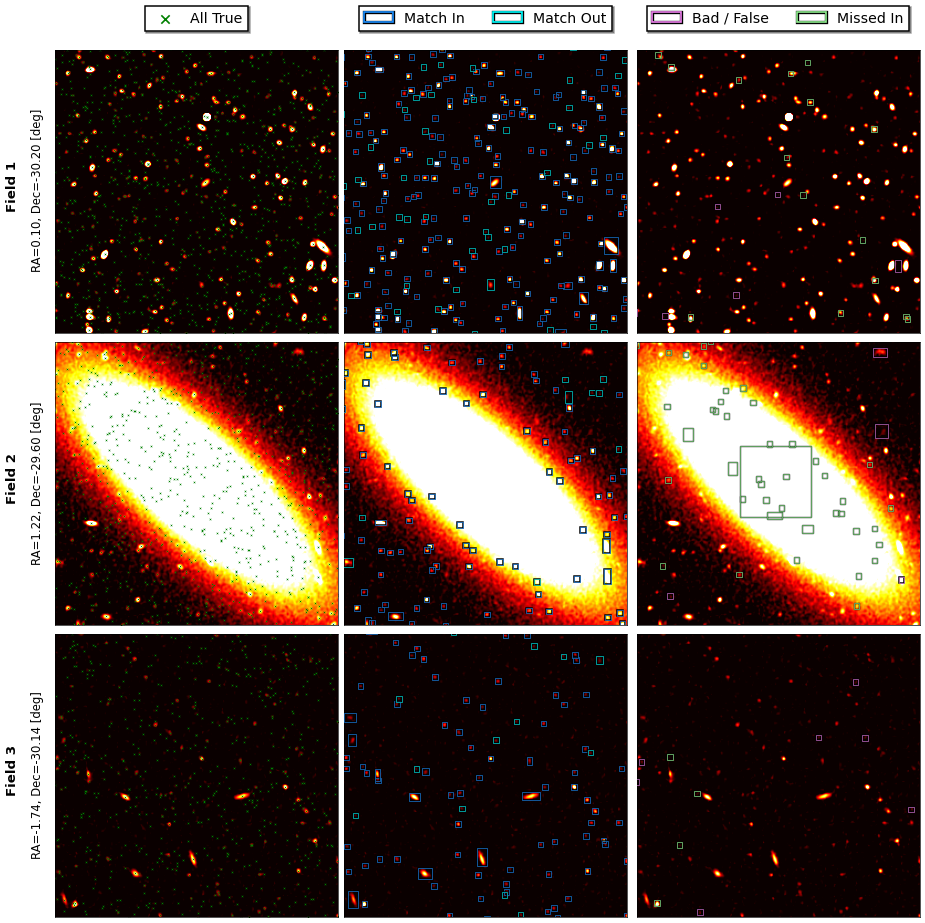

In [12]:
nb_fields = 3
fields = np.array([[0.1,-30.2],
				   [1.22,-29.60],
				   [-1.74,-30.14]])

def sim_360(val):
	tab = np.copy(val)
	for i in range(0,len(tab)):
		if (tab[i] > 180):
			tab[i] = tab[i]-360.0
	return tab

def sim_360_rev(val):
	tab = np.copy(val)
	for i in range(0,len(tab)):
		if (tab[i] < 0):
			tab[i] = 360.0 + tab[i]
	return tab

cutout_size = 256
deg_size = cutout_size*1.2*pixel_size

id_loc_mask = np.isin(target_select_boxes[:,-1], matched.id_t.to_numpy())
id_loc_found = np.where(id_loc_mask)

target_missed = np.delete(target_select_boxes, id_loc_found, axis=0)
id_loc_mask = np.isin(matched.id_t.to_numpy(), target_select_boxes[:,-1])

id_loc_found = np.where(id_loc_mask == True)[0]
id_loc_not_found = np.where(id_loc_mask == False)[0]

flagged_boxes = np.zeros((np.shape(box_catalog)[0],np.shape(box_catalog)[1]+1))
flagged_boxes[:,:-1] = box_catalog[:,:]

flagged_boxes[matched.id.to_numpy()[id_loc_found],-1] = 1
flagged_boxes[matched.id.to_numpy()[id_loc_not_found],-1] = 2

fig, axs = plt.subplots(nb_fields, 3, figsize=(15.2,5*nb_fields), dpi=60,
	gridspec_kw={'width_ratios': [1, 1, 1]}, constrained_layout=True)

for run_f in range(0,nb_fields):

	print("Coords: ra: %f (deg) dec: %f (deg)", fields[run_f,0], fields[run_f,1])
	patch = Cutout2D(full_data_norm, SkyCoord(ra=fields[run_f,0]*u.deg, dec=fields[run_f,1]*u.deg, frame="icrs"),
					 (cutout_size,cutout_size), wcs_img.celestial)

	for i in range(0,3):
		gcf = axs[run_f,i].imshow(patch.data, cmap="hot", vmax = 0.5*1.0, vmin = 0)

		axs[run_f,i].set_xlim(-0.5,cutout_size-0.5)
		axs[run_f,i].set_ylim(-0.5,cutout_size-0.5)

		axs[run_f,i].tick_params(axis='y', which='both', left=False, labelleft=False, right=False, labelright=False)
		axs[run_f,i].tick_params(axis='x', which='both', bottom=False, labelbottom=False, top=False, labeltop=False)

	missed_kept_id = np.where((np.abs(target_missed[:,0] - fields[run_f,0]) < deg_size*0.5) &
			   (np.abs(target_missed[:,1] - fields[run_f,1]) < deg_size*0.5))[0]
	target_missed_kept = target_missed[missed_kept_id,:]

	full_truth_kept_id =  np.where((np.abs(truth_dat[:,1] - fields[run_f,0]) < deg_size*0.5) &
			   (np.abs(truth_dat[:,2] - fields[run_f,1]) < deg_size*0.5))[0]

	print (np.min(flagged_boxes[:,0]), np.max(flagged_boxes[:,0]))
	kept_boxes_id = np.where((np.abs(sim_360(flagged_boxes[:,0]) - fields[run_f,0]) < deg_size*0.5) &
				(np.abs(flagged_boxes[:,1] - fields[run_f,1] < deg_size*0.5)))[0]
	kept_boxes_pred = flagged_boxes[kept_boxes_id,:]
	print (np.shape(kept_boxes_pred))

	px, py = utils.skycoord_to_pixel(SkyCoord(sim_360_rev(truth_dat[full_truth_kept_id,1])*u.deg,
				truth_dat[full_truth_kept_id,2]*u.deg, frame="icrs"), wcs=patch.wcs.celestial)

	if(np.shape(px)[0] > 0):
		axs[run_f,0].scatter(px, py, c="green", s=4.0,lw=0.6,
					   marker="x", alpha=1.0, label="All True")
		axs[run_f,0].set_title("Field %d"%(run_f+1), fontweight="bold", fontsize=16,
								rotation="vertical",x=-0.15,y=0.5, verticalalignment="center", horizontalalignment="center")
		axs[run_f,0].text(-16,cutout_size*0.5, "RA=%0.2f, Dec=%0.2f [deg]"%(fields[run_f,0], fields[run_f,1]), fontsize=14,
						  rotation="vertical", verticalalignment="center", horizontalalignment="center")

	px, py = utils.skycoord_to_pixel(SkyCoord(sim_360_rev(kept_boxes_pred[:,0])*u.deg,kept_boxes_pred[:,1]*u.deg, frame="icrs"), wcs=patch.wcs.celestial)

	for i in range(0, np.shape(kept_boxes_pred)[0]):

		xmin = px[i] - kept_boxes_pred[i,2]*0.5
		ymin = py[i] - kept_boxes_pred[i,3]*0.5
		xmax = px[i] + kept_boxes_pred[i,2]*0.5
		ymax = py[i] + kept_boxes_pred[i,3]*0.5

		if(kept_boxes_pred[i,-1] == 1):
			el = patches.Rectangle((xmin,ymin), (xmax-xmin), (ymax-ymin), linewidth=0.7, ls="-", fill=False, color="dodgerblue", zorder=3)
			c_patch = axs[run_f,1].add_patch(el)
			c_patch.set_path_effects([path_effects.Stroke(linewidth=1.8, foreground='black'),
					   path_effects.Normal()])
		elif(kept_boxes_pred[i,-1] == 2):
			el = patches.Rectangle((xmin,ymin), (xmax-xmin), (ymax-ymin), linewidth=0.7, ls="-", fill=False, color="aqua", zorder=3)
			c_patch = axs[run_f,1].add_patch(el)
			c_patch.set_path_effects([path_effects.Stroke(linewidth=1.8, foreground='black'),
					   path_effects.Normal()])
		else:
			el = patches.Rectangle((xmin,ymin), (xmax-xmin), (ymax-ymin), linewidth=0.7, ls="-", fill=False, color="violet", zorder=3)
			c_patch = axs[run_f,2].add_patch(el)
			c_patch.set_path_effects([path_effects.Stroke(linewidth=1.8, foreground='black'),
					   path_effects.Normal()])

	px, py = utils.skycoord_to_pixel(SkyCoord(target_missed_kept[:,0]*u.deg,target_missed_kept[:,1]*u.deg, frame="icrs"), wcs=patch.wcs.celestial)

	for i in range(0, np.shape(target_missed_kept)[0]):

		xmin = px[i] - target_missed_kept[i,2]*0.5
		ymin = py[i] - target_missed_kept[i,3]*0.5
		xmax = px[i] + target_missed_kept[i,2]*0.5
		ymax = py[i] + target_missed_kept[i,3]*0.5

		el = patches.Rectangle((xmin,ymin), (xmax-xmin), (ymax-ymin), linewidth=0.8, ls="-", fill=False, color="lightgreen", zorder=2)
		c_patch = axs[run_f,2].add_patch(el)
		c_patch.set_path_effects([path_effects.Stroke(linewidth=1.6, foreground='black'),
					   path_effects.Normal()])


	if(run_f == 0):
		sc_handle, sc_label = axs[run_f,0].get_legend_handles_labels()

		match_in_label = patches.Patch(color="dodgerblue", label="Match In", linewidth=2.0, fill=False)
		match_in_label.set_path_effects([path_effects.Stroke(linewidth=4.0, foreground='black'),
					   path_effects.Normal()])

		match_out_label = patches.Patch(color="aqua", label="Match Out", linewidth=2.0, fill=False)
		match_out_label.set_path_effects([path_effects.Stroke(linewidth=4.0, foreground='black'),
					   path_effects.Normal()])

		match_false_label = patches.Patch(color="violet", label="Bad / False", linewidth=2.0, fill=False)
		match_false_label.set_path_effects([path_effects.Stroke(linewidth=4.0, foreground='black'),
					   path_effects.Normal()])

		match_missed_label = patches.Patch(color="lightgreen", label="Missed In", linewidth=2.0, fill=False)
		match_missed_label.set_path_effects([path_effects.Stroke(linewidth=4.0, foreground='black'),
					   path_effects.Normal()])

		leg1 = axs[run_f,0].legend(handles=sc_handle, loc="upper center", bbox_to_anchor=(0.5,1.18),
			fancybox=False, shadow=True, ncol=1, fontsize=17, markerscale=2.0)
		leg1.legendHandles[0]._sizes = [100]
		leg1.legendHandles[0].set_linewidth(2.0)

		leg2 = axs[run_f,1].legend(handles=[match_in_label,match_out_label], loc="upper center", bbox_to_anchor=(0.5,1.18),
			fancybox=False, shadow=True, ncol=2, fontsize=17, markerscale=2.0)
		leg3 = axs[run_f,2].legend(handles=[match_false_label,match_missed_label], loc="upper center", bbox_to_anchor=(0.5,1.18),
			fancybox=False, shadow=True, ncol=2, fontsize=17, markerscale=2.0)

		leg1.get_frame().set_linewidth(1.8)
		leg1.get_frame().set_edgecolor("black")
		leg2.get_frame().set_linewidth(1.8)
		leg2.get_frame().set_edgecolor("black")
		leg3.get_frame().set_linewidth(1.8)
		leg3.get_frame().set_edgecolor("black")

plt.show()
plt.close()